In [1]:
# Import python packages that are used here
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, glob
import cmath as cm
from scipy.optimize import least_squares
from scipy.optimize import curve_fit
from glob import glob
from matplotlib.pyplot import figure
import os
import sys
import skrf as rf
# add %matplotlib widget to make plots interactive
%matplotlib widget


# Getting Started with skrf
Plot commands:

    Network.plot_s_re

    Network.plot_s_im

    Network.plot_s_mag

    Network.plot_s_db

First, we load the files ['4K/B0.s2p', '4K/C0.s2p', '4K/D0.s2p']

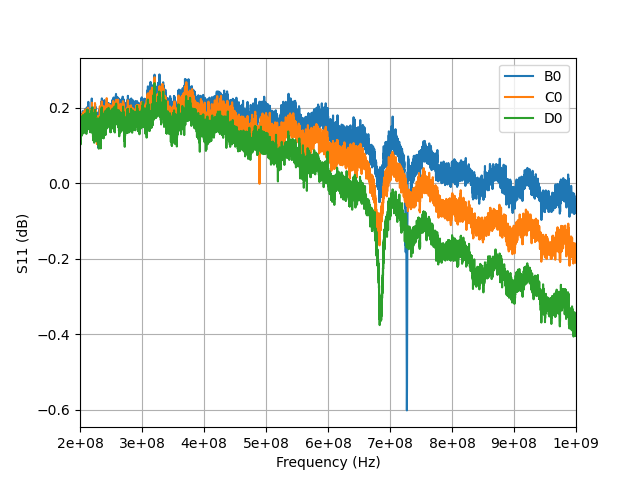

In [2]:
plt.figure()
file_name = ['4K/B0.s2p', '4K/C0.s2p', '4K/D0.s2p', 'alscn_1p2um.s2p']
B0_4K = rf.Network(file_name[0])
C0_4K = rf.Network(file_name[1])
D0_4K = rf.Network(file_name[2])
B0_RT = rf.Network(file_name[3])
B0_4K.frequency.unit = 'mhz'

B0_4K.s22['200-1000mhz'].plot_s_db(label='B0')
C0_4K.s22['200-1000mhz'].plot_s_db(label='C0')
D0_4K.s22['200-1000mhz'].plot_s_db(label='D0')

plt.ylabel('S11 (dB)')
# plt.xlim(3e8, 8e8)
plt.grid()
# plt.ion()
# plt.savefig('test_widget.png')
# plt.show(block=True)

In [3]:
B0_RT.s[:,0,0] # s11 s.shape: (20001, 2, 2)
# print(B0_RT.s.shape)

array([1.01541  -1.028120e-02j, 0.9984591-6.621263e-03j,
       0.9861077+1.521565e-04j, ..., 0.7168684-5.420626e-01j,
       0.7160732-5.420486e-01j, 0.7144063-5.427919e-01j])

In [4]:
B0_RT.f # access frequency array B0_RT.f.shape:(20001,)
# B0_RT.f.shape

array([3.00000000e+05, 3.74985000e+05, 4.49970000e+05, ...,
       1.49985003e+09, 1.49992502e+09, 1.50000000e+09])

In [5]:
B0_RT.s21 # access frequency array B0_RT.f.shape:(20001,)
for attr in dir(B0_4K.s21):
    print(attr)

COMPONENT_FUNC_DICT
PRIMARY_PROPERTIES
Y_LABEL_DICT
_M
_M_circle
_Network__compatable_for_scalar_operation_test
_P
_Q
_T
_X
_Xi
_Xi_tilde
__add__
__class__
__delattr__
__dict__
__dir__
__div__
__doc__
__eq__
__floordiv__
__format__
__ge__
__getattr__
__getattribute__
__getitem__
__gt__
__hash__
__init__
__init_subclass__
__le__
__len__
__lt__
__module__
__mul__
__ne__
__new__
__pow__
__radd__
__reduce__
__reduce_ex__
__repr__
__rmul__
__rshift__
__rsub__
__setattr__
__sizeof__
__str__
__sub__
__subclasshook__
__truediv__
__weakref__
_frequency
_generated_functions
_m
_plot_attribute_doc
_s
_z0
a
a_arcl
a_arcl_unwrap
a_db
a_db10
a_deg
a_deg_unwrap
a_im
a_mag
a_rad
a_rad_unwrap
a_re
a_time
a_time_db
a_time_impulse
a_time_mag
a_time_step
a_vswr
add_noise_polar
add_noise_polar_flatband
attribute
comments
copy
copy_from
copy_subset
crop
cropped
deembed
delay
drop_non_monotonic_increasing
encoding
extrapolate_to_dc
f
f_noise
flip
flipped
frequency
from_z
func_on_parameter
g_opt
gmm2se
group_

In [6]:
B0_RT.s_time[:,1,0] # access time component of s12 s_time.shape: (20001, 2, 2)
# B0_RT.s_time.shape

array([ 8.39882197e-07-2.83864642e-07j, -2.21115263e-06-4.19497153e-07j,
       -4.04696835e-07-1.39263711e-07j, ...,
       -1.79915228e-06-4.57882921e-07j,  2.23302922e-07+1.38196116e-06j,
        5.95170014e-07+1.63997841e-06j])

(-500.0, 2000.0)

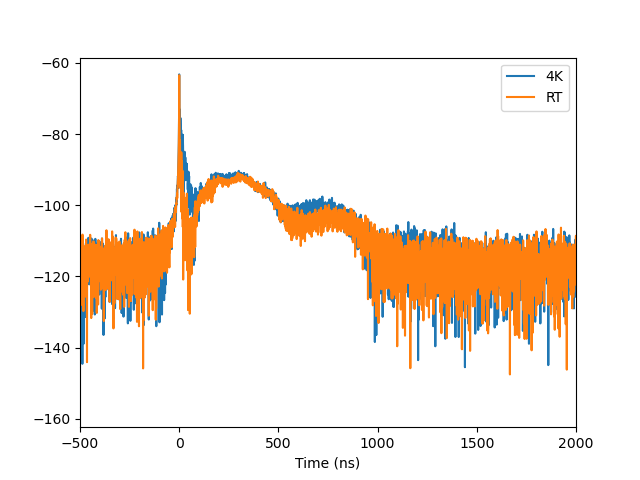

In [7]:
plt.figure()
B0_4K.s21.plot_s_time_db(label='4K')
B0_RT.s21.plot_s_time_db(label='RT')
plt.xlim(-500,2000)

In [8]:
B0_RT.s[:,0,0] # s11

array([1.01541  -1.028120e-02j, 0.9984591-6.621263e-03j,
       0.9861077+1.521565e-04j, ..., 0.7168684-5.420626e-01j,
       0.7160732-5.420486e-01j, 0.7144063-5.427919e-01j])

Text(0, 0.5, 'S11 (dB)')

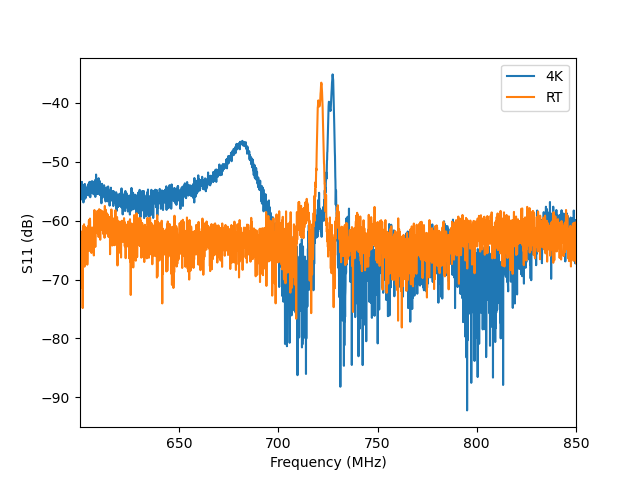

In [9]:
plt.figure()
B0_RT.frequency.unit = 'mhz'
B0_4K.s21['600-850mhz'].plot_s_db(label='4K')
B0_RT.s21['600-850mhz'].plot_s_db(label='RT')
plt.ylabel('S11 (dB)')

# Analyzing S11 efficiency

Define the BVD model first:

In [10]:
# Modified BVD model excluding the admittance Ya(omega) but including the series inductive lump elements
def modified_BVD_model_background(freq, Ls, Rs, Rp, Cp):
    """
    Calculates the modified BVD model for resonance.

    Parameters:
    - freq (array-like): Array of frequencies.
    - Lm (float): Inductance value in nH.
    - Cm (float): Capacitance value in nF.
    - Rm (float): Resistance value in Ohms.

    Returns:
    - Y (complex): Admittance value, a complex number.

    """
    N = len(freq)
    freq = freq[: N//2]
    jOmega = 1j*2*np.pi*np.array(freq)

    # Refer the circuit model to the reference paper: (doi/10.1002/adma.202305434)

    Ls = Ls*1e-9 

    Cp= Cp*1e-9 
    
    Zp =  1/(jOmega*Cp + 1/Rp)
    
    return jOmega * Ls + Rs + Zp 

def modified_BVD_model_resonance(freq, Lm, Cm, Rm):

    """
    This function calculates the admittance of a modified Butterworth-Van Dyke (BVD) model at resonance.

    Parameters:
    freq (array-like): The frequencies at which to calculate the admittance.
    Lm (float): The motional inductance in nH.
    Cm (float): The motional capacitance in fF.
    Rm (float): The motional resistance in Ohms.

    Returns:
    complex: The admittance at the given frequencies.

    Note:
    The function converts the input parameters to SI units before calculation.
    The return value is a complex number representing the admittance.
    """
     
    # Convert the unit to SI unit 
    # Cm = Cm*1e-14 #F
    Cm = Cm*1e-9 #F
    Lm = Lm*1e-9 #H
    
    # Calculate the angular frequency
    Omega = 2*np.pi*np.array(freq) #Rad
    ws = 1/np.sqrt(Lm*Cm) #Rad/s

    # Calculate the admittance Ya
    Y = ( Rm * (Omega * Cm)**2 - 1j * Omega * Cm * ( (Omega/ws)**2 - 1) ) / ( (Rm * Omega * Cm)**2 + ((Omega/ws)**2 - 1)**2 )
    return Y # Is a complex number

In [11]:
a = np.array([1, 2, 3, 4])
b = np.array([1, 2, 3])
c = np.array([2, 3])
np.hstack([a, a])
# np.concatenate((a, b, c))

array([1, 2, 3, 4, 1, 2, 3, 4])

In [12]:
def hstack_BVD_for_fit(Z):
    return np.hstack((Z.real, Z.imag))

# Convert the S11 data to impedance
def convert_s11_to_impedance(s11_pol):
    s11_pol = np.array(s11_pol)
    imp_pol = 50 * (1+s11_pol) / (1-s11_pol)
    return imp_pol

# Covert the fitted load to S11 data
def convert_imped_to_s11(impedance):
    impedance = np.array(impedance)
    s11_pol = (impedance - 50) / (impedance + 50)
    return s11_pol

def fit_BVD_model_background(freq, Impedance_data, start1, end1, start2, end2, p0, bounds, ftol, max_nfev,
                                
                                print_params = True, plot_fit=False, s11_pol=None, BG_fit_params_manual=None):

    # Find the indices of the range in xdata
    start_idx1 = np.argmin(np.abs(freq - start1))
    end_idx1 = np.argmin(np.abs(freq - end1))
    start_idx2 = np.argmin(np.abs(freq - start2))
    end_idx2 = np.argmin(np.abs(freq - end2))



    # print('freq is: ', freq)
    # print('start1: ', start1)
    # print('temp: ', freq - start1)
    # print('diff: ', start_idx1)

    # print('DEBUGGING: ')
    # print(freq[start_idx1])
    # print(freq[end_idx1])
    # print(freq[start_idx2])
    # print(freq[end_idx2])
    # Slice xdata and ydata to the two specified ranges and concatenate them
    x_fit_full = freq[start_idx1: end_idx2]
    print('x_fit full shape', x_fit_full.shape)
    y_fit_smoothened = np.linspace(Impedance_data[end_idx1], Impedance_data[start_idx2], start_idx2 - end_idx1)
    print('y_fit smoothened', y_fit_smoothened.shape)
    y_fit_full = np.concatenate((Impedance_data[start_idx1:end_idx1], y_fit_smoothened, Impedance_data[start_idx2:end_idx2])) 
    print('y_fit full shape', y_fit_full.shape)
    x_fit = np.concatenate((freq[start_idx1:end_idx1+1], freq[start_idx2:end_idx2+1]))
    y_fit = np.concatenate((Impedance_data[start_idx1:end_idx1+1], Impedance_data[start_idx2:end_idx2+1]))
    y_fit_full_stacked = np.hstack((y_fit_full.real, y_fit_full.imag))
    print('y_fit_full_stack shape', y_fit_full_stacked.shape)
    x_fit_full_stacked = np.hstack((x_fit_full.real, x_fit_full.imag))
    print('x_fit_full_stack shape', x_fit_full_stacked.shape)
    # print('xy_fit shape:')
    # print(x_fit.shape)
    # print(y_fit.shape)
    # y_fit_stacked = np.hstack((y_fit.real, y_fit.imag))
    # print(y_fit_stacked.shape)
    # print(np.hstack((y_fit.real, y_fit.imag).shape))

    x_stack = np.hstack((x_fit, x_fit))
    y_stack = np.hstack((y_fit.real, y_fit.imag))
    print('x stack: ', x_stack.shape)
    print('y stack: ', y_stack.shape)
    # Perform fitting
    # popt, _, = curve_fit(lambda freq, Ls, Rs, Rp, Cp:
    #                     hstack_BVD_for_fit(modified_BVD_model_background(freq, Ls, Rs, Rp, Cp)),
    #                     np.hstack((x_fit, x_fit)),
    #                     np.hstack((y_fit.real, y_fit.imag)),
    #                     p0= p0,
    #                     bounds = bounds
    #                     )
    # plt.plot(freq, y_fit_full.real)
    # plt.plot(freq, y_fit_full.imag)
        # Perform fitting
    popt, _, = curve_fit(lambda freq, Ls, Rs, Rp, Cp:
                        hstack_BVD_for_fit(modified_BVD_model_background(freq, Ls, Rs, Rp, Cp)),
                        x_fit_full_stacked,
                        y_fit_full_stacked,
                        p0= p0,
                        bounds = bounds,
                        ftol=1e-8
                        )
    
    Ls, Rs, Rp, Cp = popt[0], popt[1], popt[2], popt[3] 
    if BG_fit_params_manual is not None:
        Ls, Rs, Rp, Cp = BG_fit_params_manual[0], BG_fit_params_manual[1], BG_fit_params_manual[2], BG_fit_params_manual[3] 
    
    if print_params == True:
        print('Ls =', popt[0], 'nH')
        print('Rs =', popt[1], 'Ohm')
        print('Rp =', popt[2], 'Ohm')
        print('Cp =', popt[3], 'nF')
        print(_)
        
    imped_fit = modified_BVD_model_background(np.hstack((freq, freq)), Ls, Rs, Rp, Cp)
    s11_fit = convert_imped_to_s11(imped_fit)

    print(freq.shape)
    print(s11_fit.shape)
    if plot_fit:
        plt.figure()
        plt.plot(freq, abs(s11_fit))
        plt.plot(freq, abs(s11_pol))

    return s11_fit, imped_fit, popt



In [13]:
def fit_BVD_model_resonances(freq, Impedance_data,
                            start1, end1, start2, end2,
                            p0, bounds, ftol, bg_params = [0.17, 4.13, 34.19, 3.14e-3], print_params = True, 
                            Lm=4.65506298e-01, Cm=5.00635523e-02, Rm=8.01179481e-08, manual_fitting = True):

    # Find the indices of the range in xdata
    start_idx1 = np.argmin(np.abs(freq - start1))
    end_idx1 = np.argmin(np.abs(freq - end1))
    start_idx2 = np.argmin(np.abs(freq - start2))
    end_idx2 = np.argmin(np.abs(freq - end2))

    # Slice xdata and ydata to the two specified ranges and concatenate them
    Freq_fit = np.concatenate((freq[start_idx1:end_idx1 + 1], freq[start_idx2:end_idx2 + 1]))
    Admittance_fit = 1/np.concatenate((Impedance_data[start_idx1:end_idx1 + 1], Impedance_data[start_idx2:end_idx2 + 1]))

    # Rs, R0, and C0 units are Ohm, Ohm, and nF. 
    #L0, Rs, R0, C0 = bg_params[0]*1e-9, bg_params[1]-1.1, bg_params[2], (bg_params[3]-1e-4)*1e-9
    Ls, Rs, Rp, Cp = bg_params[0] * 1e-9, bg_params[1], bg_params[2], (bg_params[3]) * 1e-9
    def Z0_para(freq, Rp, Cp):
        Omega = 2*np.pi*np.array(freq) #Rad
        return np.array(1 / (1 / Rp + 1j * Omega * Cp))
    
    # # Perform fitting
    # popt, _  = curve_fit(lambda f, Lm1, Cm1, Rm1:
    #                     hstack_BVD_for_fit(1/( 2 * np.pi * np.array(f) * Ls 
    #                                            + Rs 
    #                                            + 1/(1/Z0_para(f, Rp, Cp) 
    #                                                 + modified_BVD_model_resonance(f, Lm1, Cm1, Rm1)
    #                                            )
    #                                         )
    #                                       ),
    #                     Freq_fit,
    #                     np.hstack((Admittance_fit.real, Admittance_fit.imag)),
    #                     p0= p0,
    #                     bounds = bounds,
    #                     ftol=1e-16,
    #                     )

    # Perform fitting
    # popt, _  = curve_fit(lambda f, Lm1, Cm1, Rm1:
    #                     hstack_BVD_for_fit(1/( 2 * np.pi * 1j * np.array(f) * Ls 
    #                                            + Rs 
    #                                            + 1/(1/Z0_para(f, Rp, Cp) 
    #                                                 + modified_BVD_model_resonance(f, Lm1, Cm1, Rm1)
    #                                            )
    #                                         )
    #                                       ),
    #                     Freq_fit,
    #                     np.hstack((Admittance_fit.real, Admittance_fit.imag)),
    #                     p0= p0,
    #                     bounds = bounds,
    #                     )

    popt, _  = curve_fit(lambda f, Lm1, Cm1, Rm1:
                    hstack_BVD_for_fit(1/( 2 * np.pi * 1j * np.array(f) * Ls 
                                            + Rs 
                                            + 1/(1/Z0_para(f, Rp, Cp) 
                                                + modified_BVD_model_resonance(f, Lm1, Cm1, Rm1)
                                            )
                                        )
                                        ),
                    Freq_fit,
                    np.hstack((Admittance_fit.real, Admittance_fit.imag)),
                    p0= p0,
                    bounds = bounds,
                    )

    # Assign the fitted parameters
    Lm1, Cm1, Rm1 = popt[0], popt[1], popt[2]
    if manual_fitting is True:
        Lm1, Cm1, Rm1 = Lm, Cm, Rm
    
    # Calculate the admittance of the 4 resonances
    jOmega = 1j * 2 * np.pi * np.array(freq)
    Y1 = modified_BVD_model_resonance(freq, Lm1, Cm1, Rm1)
    Y_N = Y1 
    Y_list = [Y1]
    # Calculate the total impedance
    Z_total = jOmega * Ls + Rs + 1 / (1 / Z0_para(freq, Rp, Cp) + Y_N)
    
    # Convert impedance to s11
    s11_fit = convert_imped_to_s11(Z_total)
    
    if print_params == True:
        print(popt)
    
    return s11_fit, Z_total, popt, Y_list

In [14]:
def plot_fit(freq, Impedance_data, imped_fit, s11_pol, s11_fit):
    # fig = plt.figure(figsize=(12,5))
    # fig = plt.figure(4)
    plt.figure()
    ax1 = plt.subplot(221)
    ax2 = plt.subplot(222)
    ax3 = plt.subplot(223)
    ax4 = plt.subplot(224)

    ax1.plot(freq, Impedance_data.real, label = 'data_real')
    ax1.plot(freq, (imped_fit).real, label = 'fit_real')
    ax1.plot(freq, Impedance_data.imag, label = 'data_imag')
    ax1.plot(freq, (imped_fit).imag, label = 'fit_imag')
    # ax1.set_xlim(0.71*10**9, 0.73*10**9)
    # ax1.set_ylim(-10, 10)

    ax2.plot(freq, abs(Impedance_data), label ='real Z_0 data abs')
    ax2.plot(freq, abs(imped_fit), label ='fitted Z_0 data abs')
    # ax2.set_xlim(0.71*10**9, 0.73*10**9)
    # ax2.set_ylim(-10, 10)

    ax3.plot(freq, s11_pol.real, label = 'data_real')
    ax3.plot(freq, (s11_fit).real, label = 'fit_real')
    ax3.plot(freq, s11_pol.imag, label = 'data_imag')
    ax3.plot(freq, (s11_fit).imag, label = 'fit_imag')
    # ax3.set_xlim(0.71*10**9, 0.73*10**9)
    # ax3.set_ylim(-10, 10)

    ax4.plot(freq, abs(s11_pol), label ='real s11 data abs')
    ax4.plot(freq, abs(s11_fit), label ='fitted s11 data abs')
    # ax4.set_xlim(0, 0.15*10**10)
    # ax4.set_ylim(0.8, 1)
    # ax4.set_xlim(0.7*10**9, 0.8*10**9)
    # ax4.set_ylim(0.8, 1.2)

    # fig.tight_layout()

before normalization: abs: 
1.019204111563216
after normalization: abs: 
0.9999999999999999
x_fit full shape (16003,)
y_fit smoothened (2667,)
y_fit full shape (16003,)
y_fit_full_stack shape (32006,)
x_fit_full_stack shape (32006,)
x stack:  (26676,)
y stack:  (26676,)
Ls = 1.020651134879903 nH
Rs = 0.8001702930381376 Ohm
Rp = 11703.549283441129 Ohm
Cp = 0.0007567018481585289 nF
[[ 2.46438431e-04 -5.56539525e-05  5.51791868e-05 -1.57092364e-09]
 [-5.56539525e-05  7.40349510e-03  2.36031250e+00  1.31051720e-09]
 [ 5.51791868e-05  2.36031250e+00  2.05546589e+03  3.04876587e-07]
 [-1.57092364e-09  1.31051720e-09  3.04876587e-07  2.71240757e-14]]
(20001,)
(20001,)
[3.01441e+05 1.59000e-07 3.40600e+03]


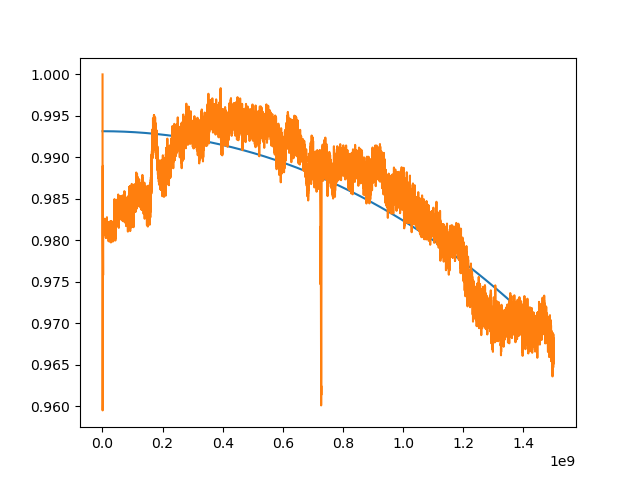

In [17]:
# %matplotlib widget
# plt.clf()
# plt.figure(1)
file_name = ['4K/B0.s2p', 'RT/B0.s2p', '4K/B4.s2p', 'RT/B1.s2p', '', '', '', 'alscn_1p2um.s2p']
B0_4K = rf.Network(file_name[0])
B0_RT = rf.Network(file_name[0])


# Load the data from the imported network in skrf
s11_pol = B0_RT.s[:,0,0]
# Normalize s11_pol:
print('before normalization: abs: ')
print(np.max(np.absolute(s11_pol)))
max = np.max(np.absolute(s11_pol))
s11_pol = s11_pol / max
# print(s11_pol)
print('after normalization: abs: ')
print(np.max(np.absolute(s11_pol)))
freq = B0_RT.f
plot = True

# Define the fitting range (for 4K)
start_bg, end_bg = 0.3e9, 0.71e9 #Hz
start_bg2, end_bg2 = 0.74e9, 1.5e9
start_reso, end_reso = 0.725e9, 0.726e9
start_reso2, end_reso2 = 0.726e9, 0.730e9
# Define the fitting range (for RT)
start_bg, end_bg = 0.2e9, 0.6e9 #Hz
start_bg2, end_bg2 = 0.8e9, 1.4e9
start_reso, end_reso = 0.72e9, 0.725e9
start_reso2, end_reso2 = 0.725e9, 0.73e9

# Define the initial fitting params
# p0_bg = [0.2, 1e-6, 500, 1e-2]
# p0_bg = [0.2, 1e-6, 500, 1e-2]
p0_bg = [0.8, 4e-6, 2000, 4e-2]
p0_bg = [6.4, 5.99, 27963, 0.00478]
p0_bg = [1.8031, 4.6535, 14544.0122, 0.00073983] 
p0_bg = [1.7877, 4.7303, 12239.0122, 0.00073983] # LS, RS, RP, CP
# p0_reso = [10, 1, 1000] # Lm, Cm, Rm
p0_reso = [10, 1, 1000] # Lm, Cm, Rm
# try new parameters
p0_reso = [301441, 1.59e-7, 3406] # Lm, Cm, Rm
# p0_reso = [300000, 2e-7, 3000] # Lm, Cm, Rm

# Set bounds on the parameters
# bounds_bg = ((1e-2, 1e-10, 0, 1e-5), (200, np.inf, np.inf, 10)) # Ls, Rs, Rp. Cp
bounds_bg = ((1e-2, 1e-10, 0, 1e-5), (200, np.inf, np.inf, 10)) # Ls, Rs, Rp. Cp
bounds_bg = ((0, 0, 0, 0), (np.inf, np.inf, np.inf, np.inf)) # Ls, Rs, Rp. Cp
bounds_reso = ((0, 0, 0), (800000, 30, 5000)) # Lm, Cm, Rm

# Set tolerance
ftol = 1e-6
max_nfev = 1e10

# Actual fitting functions below
Impedance_data = convert_s11_to_impedance(s11_pol)

# try:
BG_fit_params_manual = [6.4, 5.99, 27963, 0.00478] 
BG_fit_params_manual = [1.8031, 4.6535, 14544.0122, 0.00073983] 
_, _, BG_fit_params = fit_BVD_model_background(freq, Impedance_data, start_bg, end_bg, start_bg2, end_bg2, 
                                                p0_bg, bounds_bg, ftol, max_nfev, 
                                                plot_fit=True, s11_pol=s11_pol, 
                                                BG_fit_params_manual=BG_fit_params_manual)
BG_fit_params_copy = BG_fit_params
s11_fit, Z_total, popt, Y_list   = fit_BVD_model_resonances(freq, Impedance_data,
                                                                start_reso, end_reso, start_reso2, end_reso2,
                                                                p0_reso, bounds_reso, ftol=1e-6, bg_params = BG_fit_params_manual, print_params = True,
                                                                Lm=1000,
                                                                Cm=10,
                                                                Rm=1e-5,
                                                                manual_fitting=True
                                                                )

# BG_fit_params_manual = [6.4, 5.99, 27963, 0.00478] 
# BG_fit_params_manual = [1.8031, 4.6535, 14544.0122, 0.00073983] 
# # 'Rs = 4.6535 ohm, Ls = 1.8031 nH, Rl = 14544.0122 ohm, Cl = 0.00073983 nF'
# s11_fit, Z_total, popt, Y_list   = fit_BVD_model_resonances(np.stack((freq, freq)), Impedance_data,
#                                                                 start_reso, end_reso, start_reso2, end_reso2,
#                                                                 p0_reso, bounds_reso, ftol=0, 
#                                                                 bg_params = BG_fit_params, print_params = True,
#                                                                 Lm=301441,
#                                                                 Cm=1.59e-7,
#                                                                 Rm=3406,
#                                                                 manual_fitting=False
#                                                                 )
# print('resonance params')
# print(popt)

# if plot == True:
#     plot_fit(freq, Impedance_data, Z_total, s11_pol, s11_fit)

# except:
#     print('Fit failed')
# plt.show(block=True)

In [22]:
# print(BG_fit_params)
# #Fit_params_4K = [0.1e-1, 6, 0.6e2, 1.5e-3]

# # Generate some example frequency
# Y3 = modified_BVD_model_resonance(freq, Lm=0.01, Cm=0.8, Rm=1) # Signal at 4.8 GHz

# # Calculate Z0
# jOmega = 1j * 2 * np.pi * freq
# Ls, Rs, Rp, Cp = BG_fit_params[0] * 1e-9, BG_fit_params[1], BG_fit_params[2], (BG_fit_params[3]) * 1e-9 
# Z0 = np.array(1/(1 / Rp + jOmega * Cp)) 

# # Calculate the N combined admittances
# Y_N = Y3

# # Calculate the total impedance
# Z_total = jOmega * Ls + Rs + 1/(1/Z0 + Y_N)  

# # Calculate the total impedance
# Y_total = 1 / Z_total 

# # Calculate the S11 from total impedance
# s11_fit = convert_imped_to_s11(Z_total)

# # Plot the fitted admittance and the S11
# plot_fit(freq, Impedance_data, Z_total, s11_pol, s11_fit)

# #Save the variables for supporting figures
# freq_sup = freq
# Z_sup = Impedance_data
# Z_fit_sup = Z_total
# S11_data_sup = s11_pol
# S11_fit_sup = s11_fit

# Time-domain analysis

In [23]:
root_path = r'/Users/itungchen/UW_lab_data/'
dir_name =  root_path + '/20231206-AlScN-SOS//'

# Define the sort function of the frequency domain data
def sortdata(s):
    return int(os.path.basename(s)[1:-4])

B_data_list = glob('4K/C*.s2p')
B_data_list.sort(key = sortdata)

# Load the data to netowrk list
B_ntwk_list = []
for B in B_data_list:
    B_ntwk_list.append(rf.Network(B))

Text(0, 0.5, 'S21 (dB)')

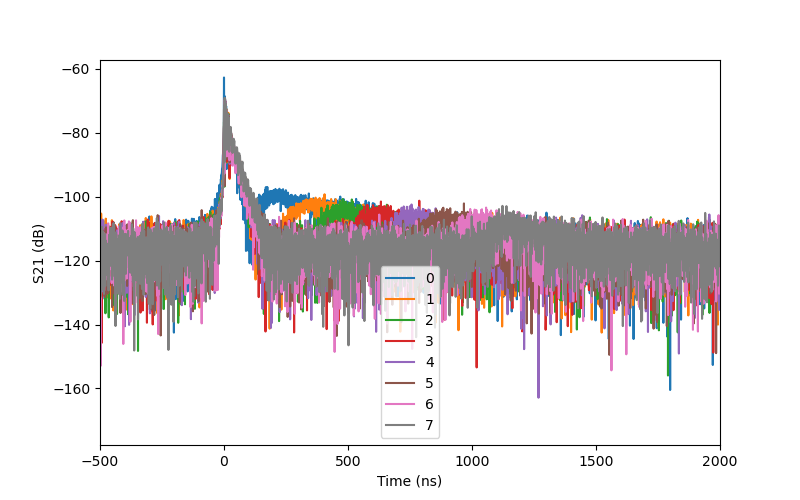

In [24]:
fig = plt.figure(figsize=(8,5))
ax1 = plt.subplot(111)

for i in range(len(B_ntwk_list)):
    B_ntwk_list[i].s21.plot_s_time_db(label=i, ax = ax1)

ax1.set_xlim(-500,2000)
ax1.set_ylabel('S21 (dB)')

Text(0, 0.5, 'S21 (dB)')

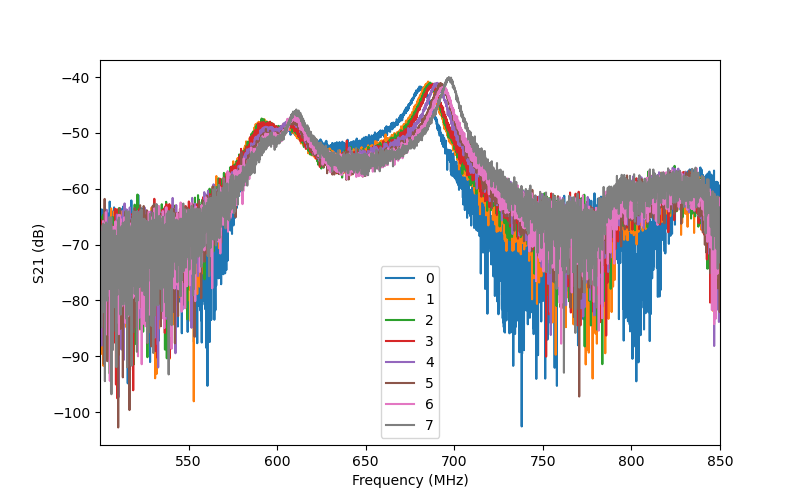

In [25]:
fig = plt.figure(figsize=(8,5))
ax1 = plt.subplot(111)

for i in range(len(B_ntwk_list)):
    B_ntwk_list[i].frequency.unit = 'mhz'
    B_ntwk_list[i].s21['500-850mhz'].plot_s_db(label=i, ax = ax1)

ax1.set_ylabel('S21 (dB)')

Text(0, 0.5, 'S21 (dB)')

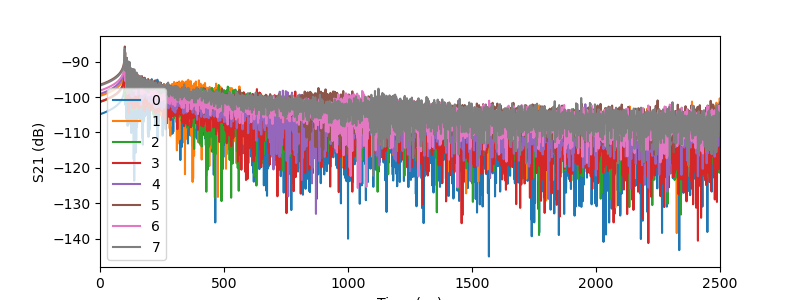

In [26]:
# Perform time-gating on each nework data
B_ntwk_list_gate = []
for i in range(len(B_ntwk_list)):
    B_ntwk_list_gate.append(rf.time.time_gate(B_ntwk_list[i].s21, 100, 2500, t_unit='ns', window = 'boxcar'))

fig = plt.figure(figsize=(8,3))
ax1 = plt.subplot(111)

for i in range(len(B_ntwk_list)):
    B_ntwk_list_gate[i].plot_s_time_db(label=i, ax = ax1)

ax1.set_xlim(0,2500)
ax1.set_ylabel('S21 (dB)')

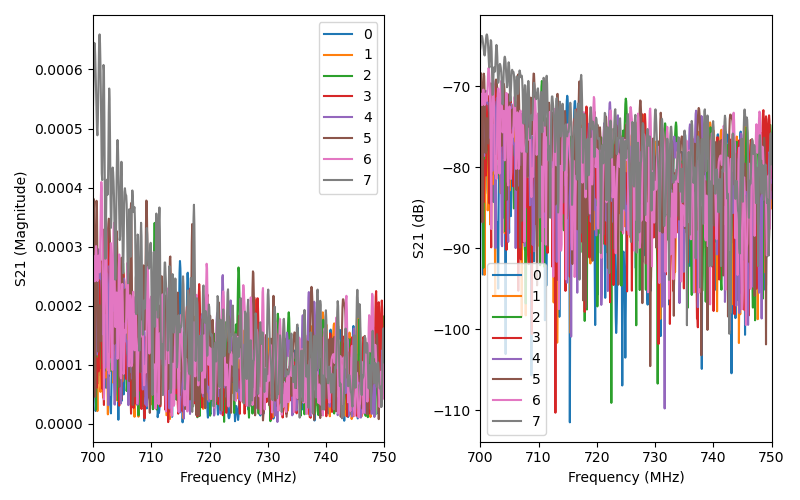

In [27]:
# Plot the time-gated data
fig = plt.figure(figsize=(8,5))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
for i in range(len(B_ntwk_list)):
    B_ntwk_list_gate[i]['700-750mhz'].plot_s_mag(label=i, ax = ax1)
    B_ntwk_list_gate[i]['700-750mhz'].plot_s_db(label=i, ax = ax2)

ax1.set_ylabel('S21 (Magnitude)')
ax2.set_ylabel('S21 (dB)')
fig.tight_layout()


In [28]:
B_ntwk_list_gate[0].s[:,0,0]

array([-0.01134917+0.02608365j, -0.00607316+0.00532243j,
       -0.00630487+0.00415251j, ..., -0.00522774+0.00189405j,
       -0.00696105+0.0059681j , -0.00682244+0.01186771j])

In [29]:
import scipy
scipy.signal.get_window(('boxcar'), 2000)

array([1., 1., 1., ..., 1., 1., 1.])

Text(0, 0.5, 'S21 (dB)')

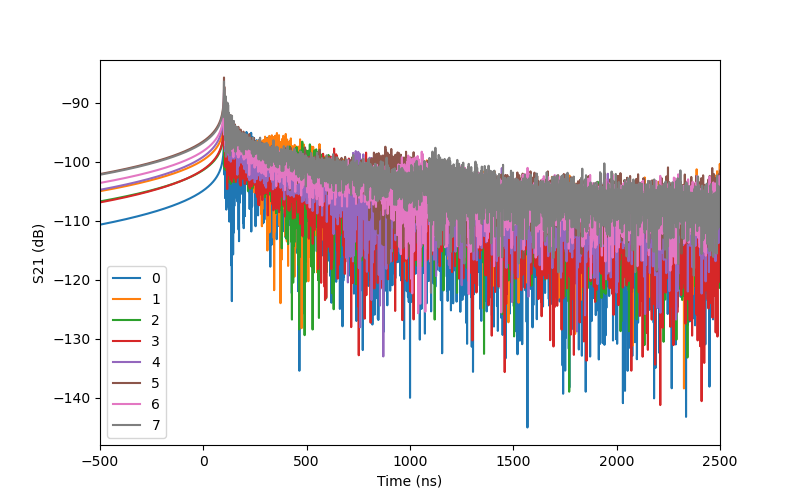

In [30]:
fig = plt.figure(figsize=(8,5))
ax1 = plt.subplot(111)

for i in range(len(B_ntwk_list)):
    B_ntwk_list_gate[i].plot_s_time_db(label=i, ax = ax1)

ax1.set_xlim(-500,2500)
ax1.set_ylabel('S21 (dB)')

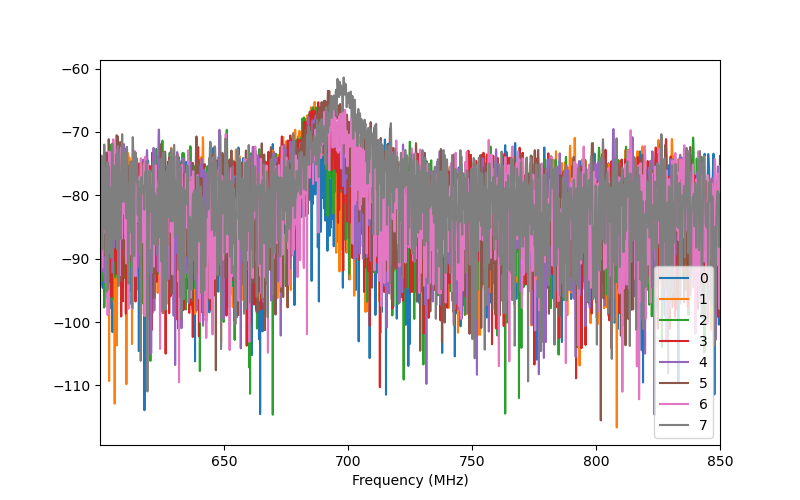

In [31]:
# Plot the time-gated data
fig = plt.figure(figsize=(8,5))
ax1 = plt.subplot(111)
for i in range(len(B_ntwk_list)):
    B_ntwk_list_gate[i]['600-850mhz'].plot_s_db(label=i, ax = ax1)

